In [35]:
import os
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
data = "/kaggle/input/alfabet-bisindo/Citra BISINDO"

In [3]:
print("Daftar folder (kelas):")
print(os.listdir(data))

Daftar folder (kelas):
['N', 'R', 'B', 'I', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'J']


In [4]:
kelas = os.listdir(data)
jumlah_per_kelas = {k: len(glob(os.path.join(data, k, "*"))) for k in kelas}

print("\nJumlah gambar per kelas:")
for k, v in jumlah_per_kelas.items():
    print(f"{k}: {v} gambar")


Jumlah gambar per kelas:
N: 12 gambar
R: 12 gambar
B: 12 gambar
I: 12 gambar
F: 12 gambar
H: 12 gambar
E: 12 gambar
U: 12 gambar
M: 12 gambar
X: 12 gambar
K: 12 gambar
Q: 12 gambar
Y: 12 gambar
S: 12 gambar
G: 12 gambar
A: 12 gambar
O: 12 gambar
T: 12 gambar
V: 12 gambar
Z: 12 gambar
C: 12 gambar
P: 12 gambar
L: 12 gambar
W: 12 gambar
D: 12 gambar
J: 12 gambar


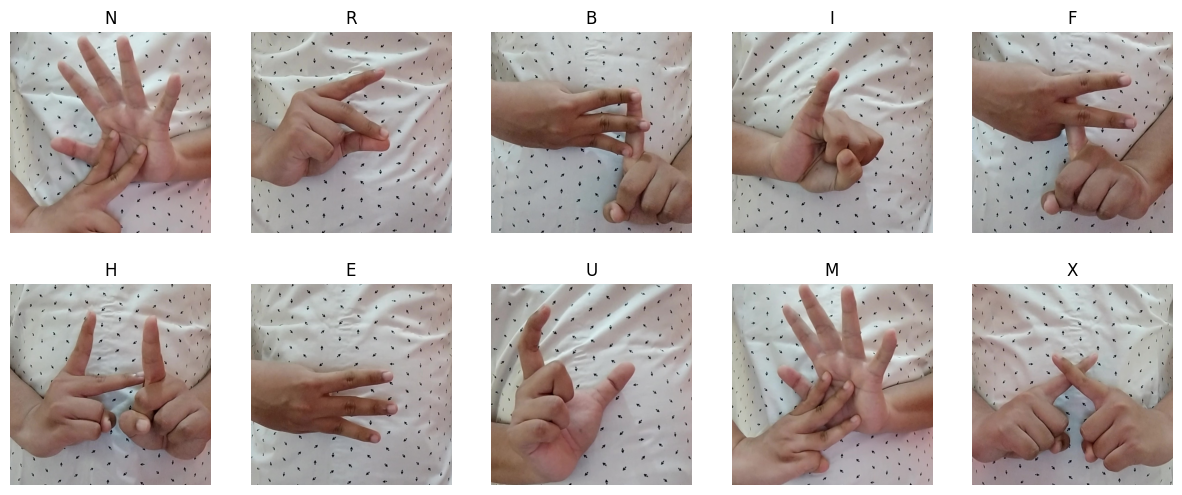

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, k in zip(axes.flatten(), kelas[:10]):
    sample_img = glob(os.path.join(data, k, "*"))[0]
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(k)
    ax.axis("off")
plt.show()

In [6]:
images = []
labels = []

In [7]:
for class_name in os.listdir(data):
    class_path = os.path.join(data, class_name)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)

In [8]:
X = np.array(images, dtype="float32")
y = np.array(labels)

In [9]:
print("Shape X:", X.shape)
print("Jumlah data:", len(y))
print("Contoh label:", np.unique(y))

Shape X: (312, 224, 224, 3)
Jumlah data: 312
Contoh label: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [10]:
X_standardized = preprocess_input(X * 255.0)

print("Contoh nilai setelah standardisasi:", X_standardized[0][0][0])

Contoh nilai setelah standardisasi: [0.09803927 0.13725495 0.12941182]


In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
sample = X[0]
sample_vis = (sample * 255).astype(np.uint8)

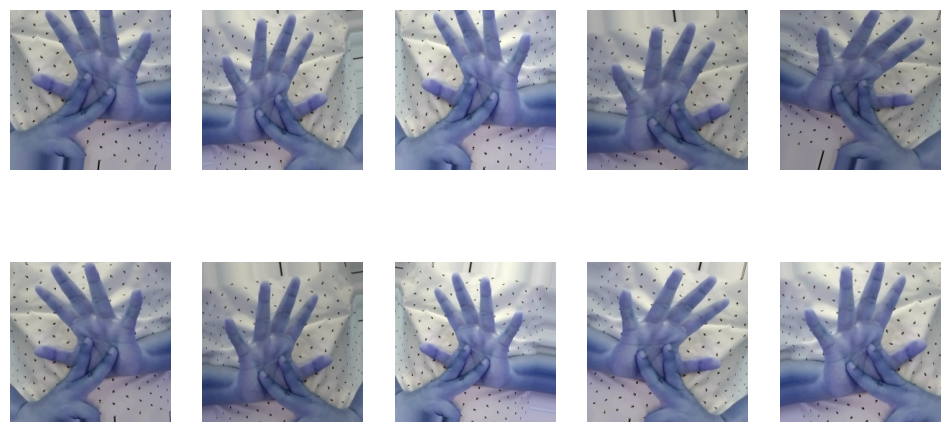

In [17]:
sample_vis = np.expand_dims(sample_vis, 0)

plt.figure(figsize=(12,6))
for i, batch in enumerate(datagen.flow(sample_vis, batch_size=1)):
    plt.subplot(2, 5, i+1)
    
    img_show = batch[0].astype(np.uint8)
    plt.imshow(img_show)
    plt.axis("off")
    
    if i == 9:
        break
plt.show()

In [18]:
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)
class_names = lb.classes_

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_standardized, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

In [20]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_val))
print(len(y_test))

(218, 224, 224, 3)
(47, 224, 224, 3)
(47, 224, 224, 3)
218
47
47


In [22]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

I0000 00:00:1758836590.731280     136 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758836590.731994     136 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
base_model.trainable = False

In [24]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(26, activation='softmax')
])

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,602 (9.89 MB)

 Trainable params: 334,618 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=16,
    shuffle=False
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1758836720.306765     203 service.cc:148] XLA service 0x7abe94007480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758836720.308081     203 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758836720.308104     203 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758836721.301192     203 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/14 ━━━━━━━━━━━━━━━━━━━━ 2:48 13s/step - accuracy: 0.0000e+00 - loss: 4.3713

I0000 00:00:1758836726.597852     203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.0457 - loss: 3.9895
Epoch 1: val_loss improved from inf to 2.70560, saving model to best_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 942ms/step - accuracy: 0.0469 - loss: 3.9753 - val_accuracy: 0.2766 - val_loss: 2.7056 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.1359 - loss: 3.1610
Epoch 2: val_loss improved from 2.70560 to 2.23516, saving model to best_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.1387 - loss: 3.1442 - val_accuracy: 0.4894 - val_loss: 2.2352 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.3900 - loss: 2.2843
Epoch 3: val_loss improved from 2.23516 to 1.87001, saving model to best_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.3885 - loss: 2.2849 - val_accuracy: 0.5957 - val_loss: 1.8700 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4689 - loss: 2.0633
E

In [32]:
best_model = load_model('best_model.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         2
           B       1.00      1.00      1.00         2
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         2
           E       1.00      0.50      0.67         2
           F       0.67      1.00      0.80         2
           G       1.00      1.00      1.00         2
           H       1.00      1.00      1.00         2
           I       1.00      0.50      0.67         2
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         2
           L       0.67      1.00      0.80         2
           M       1.00      1.00      1.00         2
           N       1.00      1.00      1.00         2
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         2
           Q       1.00      1.00      1.00

<Figure size 1200x1200 with 0 Axes>

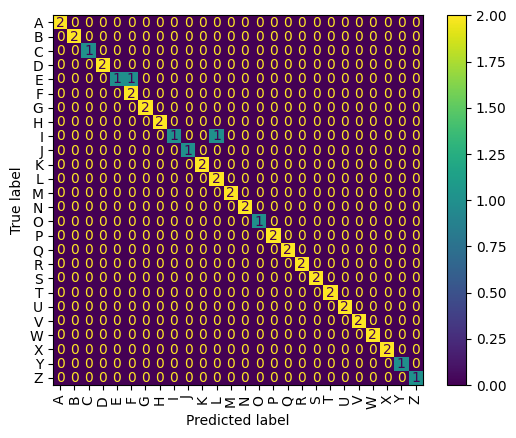

In [36]:
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(12,12))
disp.plot(xticks_rotation=90)
plt.show()